In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import sklearn
import math

# Aux data preparation functions

In [2]:
def parse_emotion(emotion,emo_dict):
    return emo_dict[emotion]
def process_pixels(pixel_str):
    pixel_lst=[int(px) for px in pixel_str.split()]
    return pixel_lst
def show_some_emotion(df,num=[3,5]):
    faces=np.random.choice(range(len(df)),size=num[0]*num[1],replace=False)
    fig,axes=plt.subplots(num[0],num[1],figsize=(num[1]*2.5,num[0]*2.5))
    for i in range(num[0]):
        for j in range(num[1]):
            face=faces[i*num[1]+j]
            axes[i][j].imshow(np.array(df['pixels'].iloc[face]).reshape(48,48),cmap='gray')
            axes[i][j].set_title(df['emotion'].iloc[face])
    plt.tight_layout()
    plt.show()
def filter_emotions(df,keep_emotions):
    return df[df['emotion'].isin(keep_emotions)]
def equalize_groups(df,label):
    largest_group=df.groupby(label).count().max()[0]
    upscaled_groups=[]
    for _,group in df.groupby(label):
        group_ratio=int(round(1.0*largest_group/len(group)))
        upscaled_groups.extend([group]*group_ratio)
    return pd.concat(upscaled_groups,axis=0,ignore_index=True)
def normalize_pixels(pixel_lst,factor=255):
    if factor=='norm':
        px_avg=np.mean(pixel_lst)
        px_std=np.std(pixel_lst)
        pixel_lst=[(1.0*px-px_avg)/px_std for px in pixel_lst]
    elif factor=='max':
        px_max=np.max(pixel_lst)
        pixel_lst=[1.0*px/px_max for px in pixel_lst]
    else:
        pixel_lst=[1.0*px/factor for px in pixel_lst]
    return pixel_lst
def prepare_data(faces_file,emo_dict,
                 emo_filter=False,
                 equalize=True,
                 sample=False,random_state=None,
                 plot_sample=[3,5],
                 normalize=255):
    df=pd.read_csv(faces_file,usecols=[0,1])
    df['emotion']=df['emotion'].map(lambda emotion: parse_emotion(emotion,emo_dict))
    if emo_filter!=False:
        df=filter_emotions(df,keep_emotions)
    if equalize:
        df=equalize_groups(df,'emotion')
    if sample:
        df=df.sample(sample,random_state=random_state)
    df['pixels']=df['pixels'].map(process_pixels)
    if plot_sample!=False:
        show_some_emotion(df,plot_sample)
    if normalize:
        df['pixels']=df['pixels'].map(lambda pixels: normalize_pixels(pixels,factor=normalize))
    X=np.array(df['pixels'].values.tolist())
    labels=list(df['emotion'].unique())
    Y=df['emotion'].map(lambda x: labels.index(x)).values
    return X,Y

# Aux NN functions

In [3]:
def one_hot_encoder(v):
    return np.eye(v.max()+1)[v]
def one_hot_decoder(v):
    return np.argmax(v,axis=1)
def sigmoid(v,derivate=False):
    if derivate:
        return v*(1-v)
    else:
        return 1/(1+np.exp(-v))
def relu(v,derivate=False):
    if derivate:
        return (v>0)
    else:
        return v*(v>0)
def tanh(v,derivate=False):
    if derivate:
        return 1-v*v
    else:
        return np.tanh(v)
def softmax(v):
    expv=np.exp(v)
    if v.shape[0]>1:
        return expv/expv.sum(axis=1,keepdims=True)
    else:
        return expv/expv.sum(axis=1)
def cross_entropy_cost(Y,P):
    return -(Y*np.log(P)).mean()
def accuracy(Y,P):
    return (Y==P).mean()
def rmse(Y,P):
    return np.sqrt(((P-Y)**2).mean())

# La classe

In [4]:
class NN_01(object):
    def __init__(self,
                 net_structure,
                 f_encode_Y=one_hot_encoder,
                 f_decode_Y=one_hot_decoder,
                 f_transfer=sigmoid,
                 f_output=lambda v: softmax(sigmoid(v)),
                 f_cost=cross_entropy_cost,
                 f_accuracy=accuracy):
        self.net_structure=net_structure
        self.f_encode_Y=f_encode_Y
        self.f_decode_Y=f_decode_Y
        self.f_transfer=f_transfer
        self.f_output=f_output
        self.f_cost=f_cost
        self.f_accuracy=f_accuracy
    def train(self,X,Y,W_0=None,
              frac_test=0.2,random_state=None,
              learning_rate=10e-7,regularization=0,num_rounds=100001,
              report_step=100,print_every=5000,print_acc=True,plot_cost=True):
        self.training_report=[]
        X,Y=sklearn.utils.shuffle(X,Y,random_state=random_state)
        num_test=int(frac_test*X.shape[0])
        X_train,Y_train=X[:-num_test],Y[:-num_test]
        X_test,Y_test=X[-num_test:],Y[-num_test:]
        eY_train,eY_test=self.f_encode_Y(Y_train),self.f_encode_Y(Y_test)
        if W_0!=None:
            self.W=W_0
        else:
            self.W=self.populate_W(X_train,eY_train)
        peY_train,peY_test=self.feed_forward(X_train),self.feed_forward(X_test)
        global_start=datetime.datetime.now()
        reporting_start=datetime.datetime.now()
        for n in range(num_rounds):
            delta=peY_train[-1]-eY_train
            for l in reversed(range(len(self.W))):
                gradient,new_delta=self.derivate_layer(self.W[l],peY_train[l],delta)
                delta=new_delta
                self.W[l]=self.W[l]*(1-learning_rate*regularization)-learning_rate*gradient
            peY_train,peY_test=self.feed_forward(X_train),self.feed_forward(X_test)
            if n % report_step==0:
                c_train,c_test=self.f_cost(eY_train,peY_train[-1]),self.f_cost(eY_test,peY_test[-1])
                pY_train,pY_test=self.f_decode_Y(peY_train[-1]),self.f_decode_Y(peY_test[-1])
                acc_train,acc_test=self.f_accuracy(Y_train,pY_train),self.f_accuracy(Y_test,pY_test)
                global_duration=(datetime.datetime.now()-global_start).total_seconds()
                if print_every and n % print_every==0:
                    global_left=global_duration*(num_rounds-n+1)/(n+1)
                    reporting_duration=(datetime.datetime.now()-reporting_start).total_seconds()
                    reporting_start=datetime.datetime.now()
                    print('{:5d} '.format(n)),
                    print('{:0.5f} {:0.5f} '.format(acc_train,acc_test)),
                    print('{:0.5f} {:0.5f} '.format(c_train,c_test)),
                    print('{:7.2f} {:7.2f}  {:7.2f}'.format(reporting_duration,global_duration,global_left))
                self.training_report.append([n,acc_train,acc_test,c_train,c_test,global_duration])
        if plot_cost:
            plt.plot([r[3] for r in self.training_report])
            plt.plot([r[4] for r in self.training_report])
            plt.show()
    def populate_W(self,X,T):
        net_structure=[X[0].size]+self.net_structure+[T[0].size]
        W=[]
        for i in range(len(net_structure)-1):
            nodes_this=net_structure[i]+1
            nodes_next=net_structure[i+1]
            W.append(np.random.randn(nodes_this,nodes_next)/np.sqrt(nodes_this+nodes_next))
        return W
    def derivate_layer(self,W_layer,layer,delta):
        next_delta=delta.dot(W_layer[:-1,:].T)*self.f_transfer(layer,derivate=True)
        layer=np.append(layer,np.ones((layer.shape[0],1)),1)
        return layer.T.dot(delta),next_delta
    def predict(self,X):
        return self.f_decode_Y(self.feed_forward(X))
    def feed_forward(self,X):
        v=[X]
        for l in range(len(self.W)-1):
            v.append(self.f_transfer(self.process_layer(v[-1],self.W[l])))
        v.append(self.f_output(self.process_layer(v[-1],self.W[-1])))
        return v
    def process_layer(self,X,W):
        X=np.append(X,np.ones((X.shape[0],1)),1)
        return X.dot(W)

# Data preparation

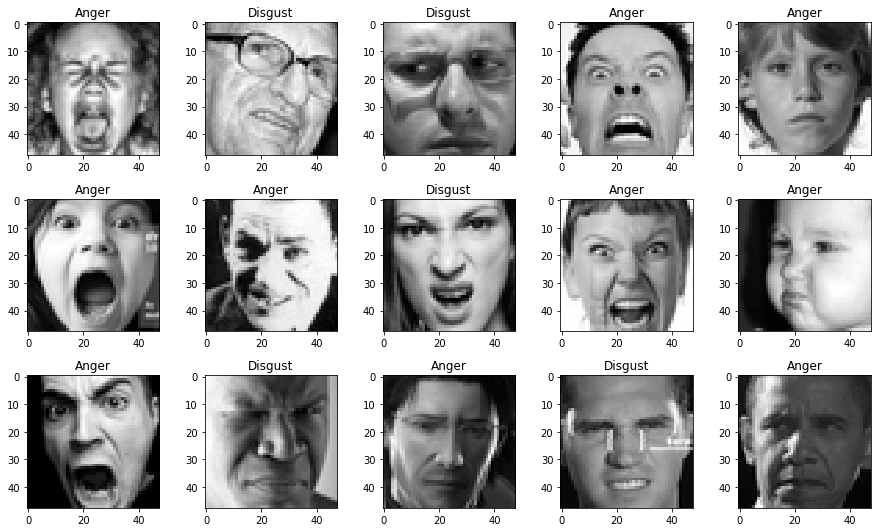

((1000, 2304), (1000,))

In [5]:
file_name='data/fer2013.csv.bz2'
emo_dict={0:'Anger',1:'Disgust',2:'Fear',3:'Happiness',4:'Sadness',5:'Surprise',6:'Neutrality'}
keep_emotions=['Anger','Disgust']
X,Y=prepare_data(file_name,emo_dict,
                 emo_filter=keep_emotions,
                 equalize=True,
                 sample=1000,random_state=None,
                 plot_sample=[3,5],
                 normalize=255)
X.shape,Y.shape

# Binary classifier

## Sigmoid

In [6]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=lambda v: v.reshape((-1,1)),
            f_decode_Y=lambda v: v.ravel().round().astype(int),
            f_transfer=sigmoid,
            f_output=sigmoid,
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.51625 0.48000  0.02952 0.02732     0.09    0.09   430.89
  500  0.53125 0.44500  0.37167 0.36746    36.50   36.58   328.75
 1000  0.57125 0.45000  0.34957 0.35806    28.92   65.50   261.88
 1500  0.58125 0.46000  0.34160 0.34727    25.46   90.96   212.22
 2000  0.58125 0.47000  0.33736 0.33745    25.41  116.36   174.58
 2500  0.58750 0.50000  0.33402 0.33071    27.91  144.28   144.33
 3000  0.58125 0.51000  0.33113 0.32614    35.59  179.87   119.99
 3500  0.58625 0.53000  0.32916 0.32294    30.15  210.01    90.10
 4000  0.57625 0.53000  0.32764 0.32062    32.50  242.52    60.74
 4500  0.58250 0.53500  0.32632 0.31878    29.31  271.83    30.32
 5000  0.58500 0.54000  0.32511 0.31723    36.93  308.76     0.12


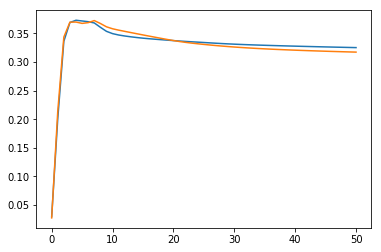

CPU times: user 9min 31s, sys: 8min 32s, total: 18min 4s
Wall time: 5min 9s


In [7]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Relu

In [8]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=lambda v: v.reshape((-1,1)),
            f_decode_Y=lambda v: v.ravel().round().astype(int),
            f_transfer=relu,
            f_output=sigmoid,
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.51000 0.43000  33.29668 39.94040     0.07    0.07   325.62
  500  0.59125 0.58500  0.24798 0.36317    33.57   33.63   302.23
 1000  0.64250 0.58500  0.28857 0.38987    32.92   66.55   266.07
 1500  0.65000 0.59000  0.29027 0.38557    33.29   99.84   232.93
 2000  0.66000 0.58500  0.28879 0.38230    24.98  124.81   187.25
 2500  0.66000 0.57000  0.29005 0.38354    25.94  150.75   150.81
 3000  0.66375 0.57500  0.29608 0.39117    28.91  179.66   119.86
 3500  0.66625 0.58000  0.29518 0.39065    30.53  210.20    90.18
 4000  0.65625 0.58500  0.29948 0.39720    28.98  239.17    59.90
 4500  0.66000 0.60500  0.30222 0.40172    30.69  269.86    30.10
 5000  0.66125 0.60000  0.30356 0.40503    25.46  295.32     0.12


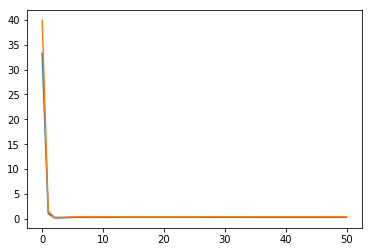

CPU times: user 8min 52s, sys: 7min 48s, total: 16min 41s
Wall time: 4min 55s


In [9]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Tanh

In [10]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=lambda v: v.reshape((-1,1)),
            f_decode_Y=lambda v: v.ravel().round().astype(int),
            f_transfer=tanh,
            f_output=sigmoid,
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.51500 0.50500  0.01866 0.05149     0.06    0.06   302.03
  500  0.54625 0.51000  0.38383 0.39709    24.06   24.12   216.72
 1000  0.58875 0.52000  0.35002 0.36613    26.01   50.13   200.42
 1500  0.60000 0.53000  0.34116 0.36369    30.95   81.08   189.16
 2000  0.60750 0.53500  0.33527 0.36361    36.84  117.92   176.90
 2500  0.60875 0.55000  0.33106 0.36420    29.34  147.26   147.32
 3000  0.61125 0.55500  0.32863 0.36411    33.23  180.49   120.41
 3500  0.64375 0.58500  0.32667 0.36391    41.81  222.30    95.37
 4000  0.66000 0.58000  0.32428 0.36372    41.46  263.76    66.06
 4500  0.66625 0.58000  0.32255 0.36368    41.40  305.16    34.04
 5000  0.66500 0.58000  0.32104 0.36311    42.48  347.64     0.14


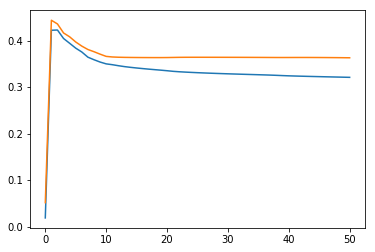

CPU times: user 9min 46s, sys: 9min 2s, total: 18min 49s
Wall time: 5min 47s


In [11]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# 2 class classifier

## Sigmoid

In [12]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.50000 0.54000  0.36709 0.35951     0.09    0.09   453.68
  500  0.54000 0.55000  0.34921 0.34595    37.50   37.59   337.75
 1000  0.54625 0.57000  0.34446 0.34259    38.33   75.92   303.52
 1500  0.56625 0.57500  0.34110 0.34078    35.10  111.02   259.01
 2000  0.57875 0.58500  0.33753 0.33919    29.71  140.73   211.13
 2500  0.59750 0.59000  0.33449 0.33767    28.62  169.35   169.42
 3000  0.61000 0.59000  0.33197 0.33609    29.31  198.66   132.53
 3500  0.62125 0.58500  0.32961 0.33485    26.33  224.99    96.52
 4000  0.63000 0.59000  0.32720 0.33389    25.34  250.33    62.69
 4500  0.63625 0.59000  0.32487 0.33307    25.42  275.75    30.75
 5000  0.64000 0.59000  0.32265 0.33228    25.59  301.34     0.12


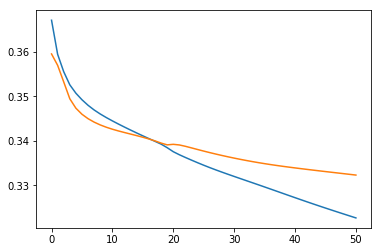

CPU times: user 9min 51s, sys: 8min 14s, total: 18min 5s
Wall time: 5min 1s


In [13]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Relu

In [14]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=relu,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.52375 0.55500  0.36568 0.35676     0.04    0.04   221.66
  500  0.61125 0.56000  0.32574 0.33482    22.47   22.51   202.32
 1000  0.68375 0.62000  0.30762 0.33522    22.44   44.96   179.74
 1500  0.72125 0.62500  0.28513 0.33024    22.22   67.18   156.73
 2000  0.76250 0.63000  0.26855 0.33015    22.23   89.40   134.13


/home/ggomarr/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp


 2500  0.80250 0.68000  0.25319 0.32021    22.38  111.78   111.82
 3000  0.80875 0.69000  0.24717 0.31359    22.22  134.00    89.39
 3500  0.78750 0.65000  0.26351 0.32973    22.38  156.38    67.09
 4000  0.79875 0.67500  0.25638 0.31913    22.17  178.55    44.72
 4500  0.79375 0.66000  0.25937 0.32508    22.11  200.67    22.38
 5000  0.78000 0.66000  0.26547 0.32663    24.89  225.56     0.09


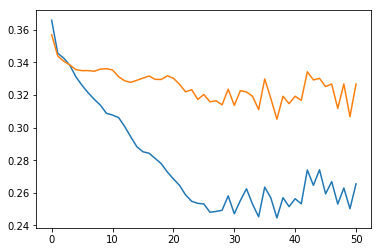

CPU times: user 9min 9s, sys: 5min 46s, total: 14min 55s
Wall time: 3min 45s


In [15]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Tanh

In [16]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=tanh,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.48875 0.44500  0.35943 0.36199     0.06    0.06   276.94
  500  0.55750 0.47500  0.34658 0.35267    31.70   31.76   285.38
 1000  0.58250 0.52500  0.34391 0.34953    26.58   58.34   233.23
 1500  0.60875 0.52000  0.34121 0.34689    25.90   84.24   196.54
 2000  0.62375 0.53000  0.33866 0.34478    25.80  110.04   165.09
 2500  0.63375 0.53500  0.33572 0.34287    25.64  135.68   135.74
 3000  0.64875 0.55500  0.33221 0.34131    26.32  162.00   108.07
 3500  0.66500 0.56500  0.32802 0.33948    26.08  188.08    80.69
 4000  0.67375 0.57000  0.32304 0.33836    26.15  214.23    53.65
 4500  0.68250 0.57000  0.31739 0.33705    27.18  241.41    26.92
 5000  0.69625 0.57500  0.31215 0.33613    25.52  266.93     0.11


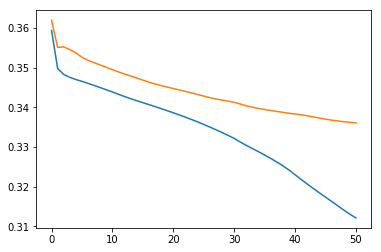

CPU times: user 9min 31s, sys: 7min 20s, total: 16min 51s
Wall time: 4min 27s


In [18]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0.2,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)